### HW 2: Training a neural network (multi-layer perceptron w/ 1 hidden layers)

아래 코드는 다음 항목을 구현한다.
1. Neural network 모델 정의 및 관련 연산
3. Gradient descent 알고리즘 및 Neural network 모델의 parameter에 대한 gradient 연산
4. 학습된 Neural network 모델 parameter를 적용하여 test data의 classification 결과 도출

In [1]:
# package 불러오기
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os

# utility functions

# function: make labels one-hot vectors
def make_labels_onehot(labels, num_cls):
    num_data = labels.shape[0]
    labels_1hot = np.zeros((num_data,num_cls))
    labels_1hot[np.arange(num_data),labels[:]] = 1
    return labels_1hot

# function: visualize sample images
def VisualizeBatchData(batch_data, batch_sz):
    f, axarr = plt.subplots(batch_sz)
    ddim_sq = int(np.sqrt(batch_data[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(batch_sz):
        axarr[i].imshow(batch_data[i][:].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

# function: visualize neuron weight matrix for gradient descent
def VisualizeWeights(W_arr, num_iter, num_cls):
    f, axarr = plt.subplots(num_iter,num_cls)
    ddim_sq = int(np.sqrt(W_arr[0].shape[0]))
    # print(W_arr[0].shape[0])
    for i in range(num_iter):
        for j in range(num_cls):
            axarr[i,j].imshow(W_arr[i][:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()

##### 셀1: 데이터 불러오기

MNIST 데이터셋은 CNN 구조 개발에 큰 공헌을 하면서 Deep learning 분야의 대가로 추앙받는 Yann LeCun 뉴욕대 교수님의 연구로 구축된 영상 데이터셋이다. 
구성 영상은 각각 28x28 크기를 가지며 0부터 9사이의 아라비아 숫자를 필기한 영상으로 각 숫자마다 동일한 수의 영상을 가진다.
총 70000장의 영상 및 레이블들로 구성되며, 각각 60000장으로 구성된 학습 데이터셋과 10000장으로 구성된 테스트 데이터셋으로 나뉜다.

data/MNIST 폴더에 해당 파일들이 이미 저장되어 있는 상태에서 다음 코드를 수행하면 MNIST 데이터셋을 로딩할 수 있다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하고, 로딩된 데이터에 대응되는 변수들의 의미를 잘 이해하자.

In [2]:
def load_mnist_data(data_dir):
    train_images_path = os.path.join(data_dir, 'train-images-idx3-ubyte.gz')
    train_labels_path = os.path.join(data_dir, 'train-labels-idx1-ubyte.gz')
    test_images_path = os.path.join(data_dir, 't10k-images-idx3-ubyte.gz')
    test_labels_path = os.path.join(data_dir, 't10k-labels-idx1-ubyte.gz')

    with gzip.open(train_images_path, 'rb') as f:
        train_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzip.open(train_labels_path, 'rb') as f:
        train_labels = np.frombuffer(f.read(), np.uint8, offset=8)

    with gzip.open(test_images_path, 'rb') as f:
        test_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzip.open(test_labels_path, 'rb') as f:
        test_labels = np.frombuffer(f.read(), np.uint8, offset=8)

    return train_images, train_labels, test_images, test_labels

# Specify the directory where the MNIST dataset files are located
data_dir = 'data/MNIST/'  # Replace with the actual directory path

# Load the MNIST dataset
# The training and test data are now available in train_images, train_labels, test_images, and test_labels.
train_images, train_labels, test_images, test_labels = load_mnist_data(data_dir)

num_imgs_tr = train_images.shape[0]
num_imgs_te = test_images.shape[0]
img_sz = train_images.shape[1]
num_cls = 10

##### 셀2: 데이터 전처리

아래 셀에서는 강의 14에서 학습한 zero-centering 데이터 전처리를 수행한다.
코드를 상세히 읽어보고 각 부분의 의미를 이해하자.

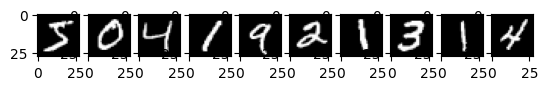

[5 0 4 1 9 2 1 3 1 4]


In [3]:
# visualize sample images and labels
num_view = 10
f, axarr = plt.subplots(1,num_view) 
for i in range(num_view):
    axarr[i].imshow(train_images[i,:,:],cmap='gray')
plt.show()
print(train_labels[:num_view])

# pre-process sample images
# flatten each image to 1D vector - # 총영상개수x28x28 영상 배열을 총영상개수x28^2 배열로 규격 변경

tr_data = train_images.reshape(num_imgs_tr, -1) # training data 전처리 
te_data = test_images.reshape(num_imgs_te, -1)# test data 전처리

tr_data = tr_data / 255.0
te_data = te_data / 255.0

# subtract mean
tr_mean = np.mean(tr_data,axis=0)
tr_data = tr_data - tr_mean
te_data = te_data - tr_mean

##### 문제3: Neural network 모델의 local gradient 연산 정의

다음 코드는 아래 그림과 같이 1개의 hidden layer를 갖는 neural network의 객체를 정의하는 class의 코드이다.

<img src="image.png" alt="neural network structure" width="320"/>

코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자. 
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

In [4]:
class MLPNeuralNetwork:
    def __init__(self, data_dim, num_hid_neurons, num_cls):
        self.data_dim = data_dim
        self.num_cls = num_cls
        # data_dim <- D in slides, num_cls <- M in slides, num_hid_neurons <- 다양하게 설정하여 실험
        self.W1 = 0.001 * np.random.randn(data_dim, num_hid_neurons)
        self.W2 = 0.001 * np.random.randn(num_hid_neurons, num_cls)
        self.b1 = np.random.randint(num_hid_neurons)
        self.b2 = np.random.randint(num_cls)
        self.scores = np.zeros(num_cls)
        self.data = 0
        self.num_data = 0
    def forward(self, data):
        # data dimension is N x D
        self.data = data
        self.hidden_input = np.dot(data, self.W1) + self.b1
        self.hidden_output = np.maximum(0, self.hidden_input)
        self.scores = np.dot(self.hidden_output, self.W2) + self.b2
        return self.scores
    def backward(self, upstream_grad):
        # upstream_grad dimensions should be N x M
        # W dimension is D x M
        # W dimension is 1 x M
        grad_W2 = np.dot(self.hidden_output.T, upstream_grad)
        grad_b2 = np.sum(upstream_grad, axis=0)

        hidden_grad = np.dot(upstream_grad, self.W2.T)
        hidden_grad[self.hidden_input <= 0] = 0
        grad_W1 = np.dot(self.data.T, hidden_grad)
        grad_b1 = np.sum(hidden_grad, axis=0)
        grad = {'W1':grad_W1, 
                'b1':grad_b1,
                'W2':grad_W2, 
                'b2':grad_b2}
        return grad
    def grad_descent(self, grad, lr):
        grad_W1 = grad['W1']
        grad_b1 = grad['b1']
        self.W1 = self.W1 - lr*grad_W1
        self.b1 = self.b1 - lr*grad_b1
        grad_W2 = grad['W2'] #수정함
        grad_b2 = grad['b2'] #수정함
        self.W2 = self.W2 - lr*grad_W2
        self.b2 = self.b2 - lr*grad_b2
   

    def visualize_weights(self):
        f, axarr = plt.subplots(self.num_cls)
        ddim_sq = int(np.sqrt(self.W1.shape[0]))
        for j in range(self.num_cls):
            axarr[j].imshow(self.W1[:,j].reshape(ddim_sq,ddim_sq),cmap='gray')
    plt.show()
    

##### 문제4: Softmax loss 함수의 local gradient 연산 정의

다음 코드는 Softmax 함수 기반의 cross-entropy loss 함수와 이를 기준으로 모델을 학습하는데 필요한 gradient를 계산하는 과정을 포함한다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자. 
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.
[아울러 SoftMaxLoss 클래스의 compute_grad 함수의 경우 아래 구현된 코드를 바탕으로 softmax 함수에 대해 정의된 multi-layer perceptron 구조의 신경망의 gradient의 수식 등을 포함한 이론을 정리하여 제시하라. 제공된 결과보고서 파일에 개별 챕터로 정리하여 제출한다.]

In [5]:
class SoftMaxLoss:
    def __init__(self, model, num_cls):
        # set model object
        self.model = model
        self.model_scores = 0
        self.softmax_probs = 0
        self.loss = 0
        self.data = 0
        self.probs = 0
        self.num_cls = num_cls
    def compute_probs(self, data):
        scores = self.model.forward(data)
        scores = scores-np.max(scores, axis=1, keepdims=True)
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        self.probs = probs
        return self.probs    
    def compute_loss(self, data, labels):
        self.data = data
        self.labels = labels
        probs = self.compute_probs(data)
        self.probs = probs
        epsilon = 1e-10
        correct_log_probs = -np.log(probs[np.arange(data.shape[0]), labels] + epsilon)
        loss = np.sum(correct_log_probs) / data.shape[0]
        self.loss = loss
        return self.loss
    def compute_grad(self):
        # score dimensions should be N x M
        z = self.probs
        # grad_z dimensions should also be N x M
        grad_z = z - make_labels_onehot(self.labels,self.num_cls)
        return self.model.backward(grad_z)


##### 문제5: Gradient descent 알고리즘 구현

다음 코드는 gradient descent 알고리즘으로 학습 데이터에 대해 MLP neural network를 학습하는 코드이다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자. 
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

loss= 2.3869607089157285
loss= 20.68728794485822
loss= 20.957122135444635
loss= 20.957122135444635
loss= 20.687287944858223
loss= 20.777232675053693
loss= 21.137011595835574
loss= 20.41745375427181
loss= 20.237564293880872
loss= 20.41745375427181
loss= 20.957122135444635
loss= 21.49679051661746
loss= 21.676679977008398
loss= 20.147619563685396
loss= 21.137011595835574
loss= 20.41745375427181
loss= 21.137011595835574
loss= 20.32750902407634
loss= 20.777232675053696
loss= 20.777232675053693
loss= 21.047066865640105
loss= 20.50739848446728
loss= 21.49679051661746
loss= 20.41745375427181
loss= 20.147619563685403
loss= 20.50739848446728
loss= 20.597343214662754
loss= 21.316901056226516
loss= 19.38689373607199
loss= 21.226956326031047
loss= 19.248172261730694
loss= 20.23756429388087
loss= 20.50739848446728
loss= 21.06443898380547
loss= 20.687287944858223
loss= 21.154459606423238
loss= 20.216518502049382
loss= 20.353157579254663
loss= 20.22383844343062
loss= 20.703835243452698
loss= 20.628875

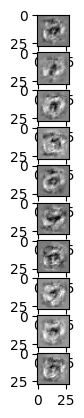

In [6]:
def get_mini_batch(batch_sz, db_data, db_labels, num_data):
    batch_indices = np.random.choice(num_data, batch_sz)
    batch_data = db_data[batch_indices]
    batch_labels = db_labels[batch_indices]
    return batch_data, batch_labels

def train_mlp_neuralnet(db_data, db_labels, num_cls, lr, batch_sz, num_iter, num_hid_neurons):
    # define & initialize MLP neural network classifier
    num_data = db_data.shape[0]
    data_dim = db_data.shape[1]
    model = MLPNeuralNetwork(data_dim, num_hid_neurons, num_cls)
    # define loss function
    loss_fn = SoftMaxLoss(model,num_cls)
    # iterative stochastic gradient descent
    for i in range(num_iter):
        # sample data mini-batch
        batch_data, batch_labels = get_mini_batch(batch_sz, db_data, db_labels, num_data)
        # compute loss value
        loss = loss_fn.compute_loss(batch_data, batch_labels)
        print('loss=',loss)
        # compute gradient (backpropagation)
        grad = loss_fn.compute_grad()
        # update model parameters using gradient
        model.grad_descent(grad, lr)
    model.visualize_weights()
    return model

lr = 0.001
batch_sz = 256
num_iter = 10000
num_hid_neurons = 256
model = train_mlp_neuralnet(tr_data, train_labels, num_cls, lr, batch_sz, num_iter, num_hid_neurons)

##### 문제6: 학습된 모델을 이용한 test data classification

다음 코드에서는 학습된 MLP neural network를 이용하여 테스트 데이터의 판별 결과를 도출한다.
코드를 먼저 상세히 읽어보고 각 부분의 의미를 이해하자. 
코드를 완성하도록 표기된 부분은 직접 코딩을 수행하여 코드가 잘 동작하도록 하여라.

다양한 실험을 통해 learning rate, batch size, number of hidden neuron 값을 다양하게 조정해 가며 Accuracy를 최대한 높게 만들어 보고, 이 과정의 세부 내용을 보고서에 명시하여라.

In [9]:
te_scores = model.forward(te_data)
exp_scores = np.exp(te_scores - np.max(te_scores, axis=1, keepdims=True))
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
predictions = np.argmax(probs, axis=1)
Acc = np.mean(predictions == test_labels)
print('Classification accuracy=', Acc)

Classification accuracy= 0.9648
